In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
import scipy
import time
#from diagonal import *
%matplotlib inline

In [7]:
class Diagonal:
    def __init__(self,n,d,precision='single',sparse=True):
        self.n = n
        self.d = d
        self.area = n*d
        self.dims = 2
        self.shape = [self.n*self.d,self.n*self.d]
        self.precision = np.float32 if 'single' else np.float64
        self.sparse= sparse
        self.table = self._create_table()
        self.matrix = self._create_matrix()
        self.basis = self._create_basis()
        self.row_based = self._create_row_representation()
        
    
    def _create_basis(self):
        return np.split(np.array(self.table[1][:self.area]),self.d)
    
    def _create_row_representation(self):
        row_wise = np.zeros((self.n,self.area))
        for ii,i in enumerate(np.repeat(range(self.matrix.shape[1]),self.d)):
            row_wise[:,ii] = self.matrix[:,i][ii%self.d::self.d]
        return row_wise
    def _create_table(self):
        ''' 
            This function will create a lookup table of indicies of where the values in the sparse
            representation exist in the full matrix
        '''
        rows = np.repeat(range(self.area),self.n)
        columns = [list(range(i,self.area,self.d)) for i in range(self.d)]
        columns = [i for c in columns for i in c] * self.n
        return rows,columns
    
    def _create_zero_matrix(self):
        return np.zeros((self.shape)).astype(self.precision)
        
    
    def _create_matrix(self):
        
        if 1 in[self.n,self.d]:
            raise AssertionError('n or d cannot be equal to 1')
        populated = self.n**2 * self.d
        values = np.random.randn(populated).astype(self.precision)
        sparse= np.reshape(values,(self.area, self.n))
        return sparse
    
    def from_dense(self,arr):
        ''' 
            This function will take a dense representation of the sparse matrix
            and recreate the sparse matrix
        '''
        matrix = self._create_zero_matrix()
        matrix[self.table] = arr.flatten()
        return matrix
    
    def _sparse_mm(self,y,left=False,batch = True):
        if batch:
            if left:
                batched = np.vstack([y[:,b] for b in self.basis])
                batched = np.reshape(batched,(self.d,y.shape[-1],self.n))
            else:
                batched = np.vstack([y[b,:] for b in self.basis])
                batched = np.reshape(batched,(self.d,self.n,y.shape[-1]))
            #batched = np.vstack([batched for _ in range(self.n)])
        if left:
            return np.vstack([np.dot(batched[ii%self.d],i) for ii,i in enumerate(self.row_based.T)]).T
        else:
            return np.vstack([np.dot(i,batched[ii%self.d]) for ii,i in enumerate(diag.matrix)])
        
    @staticmethod
    def _swap_elements(l,i,j):
        new = l.copy()
        new[i],new[j] = j,i
        return new
    
    
    def get_permutation_dense(self):
        diags = np.repeat(np.arange(0,self.n),self.d)
        updated = self.row_based.copy()
        for c in range(updated.shape[1]):
            max_idx = np.argmax(np.abs(self.row_based[diags[c]:,c]))
            max_idx += diags[c]
            if (max_idx != diags[c]) and (max_idx > diags[c] ):

                order = self._swap_elements(list(range(updated.shape[0])),max_idx,diags[c])
                basis = self.basis[c%self.d]
                updated[:,basis] = updated[:,basis][[order],:]
        return updated
    
    @staticmethod
    def create_pivot(mat):
        mat_size = mat.shape[0]
        p_blank = np.eye(mat_size)
        for c in range(mat_size):
            row = max(range(c, mat_size), key=lambda i: abs(mat[i,c]))
            if c != row:
                p_blank[[c,row]] = p_blank[[row,c]]
        return p_blank
        
    
    def mm(self,y,x=None,sparse=True,left=False):
        if sparse:
            return self._sparse_mm(y,left=left)
        else:
            assert x is not None
            return np.dot(x,y)
        
   
        
    def plu(self):
        L = np.eye(self.area)
        U = np.zeros((self.area,self.area))
        #P = self.create_pivot(self.from_dense(self.matrix))
        PA = self.get_permutation_dense()

        for j in range(self.area):

            basis = self.basis[j%self.d]
            Uupdatedable = [b for b in basis if b<=j]
            Lupdatedable = [b for b in basis if b>j]

            for ii,i in enumerate(basis):
                if i <= j:
                    if len(Uupdatedable) == 1:
                        value = PA[ii,j]
                    else:
                        value= PA[ii,j] - (U[Uupdatedable[:ii+(1-j%2)],j] *L[basis[ii],Uupdatedable[:ii+(1-j%2)]]).sum()
                    U[i,j] = value

                
            #for ii,i in enumerate(basis):
                if i > j:
                    if len(Lupdatedable)>self.d:
                        value = PA[ii,j] / U[j,j]
                    else:
                        value = (PA[ii,j] -(L[basis[ii],range(j)] * U[range(j),j]).sum()) / U[j,j]
                    L[i,j] = value


        return(PA,L,U)
    
            
        
        

In [88]:
import math

In [3]:
x = np.random.randn(16,16)

In [3]:
diag = Diagonal(2,2)
new_normal = diag.from_dense(diag.matrix)

In [61]:
np.allclose(diag.mm(x,sparse=True,left=False),diag.mm(x,new_normal,sparse=False))

True

In [62]:
np.allclose(diag.mm(x,sparse=True,left=True),diag.mm(new_normal,x,sparse=False,left=True))

True

In [28]:
%%timeit
np.dot(new_normal,x)

7.88 s ± 18.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
import time
start = time.time()
diag.mm(x,new_normal,sparse=False)
end = time.time()
print(end - start)

7.910259246826172


In [11]:
def return_time(function,x,kwargs={}):
    start = time.time()
    function(x,**kwargs)
    end = time.time()
    return end-start

In [3]:
def return_time(function,args,kwargs={}):
    start = time.time()
    function(*args,**kwargs)
    end = time.time()
    return end-start

In [ ]:
def return_time(function,args,kwargs={}):
    start = time.time()
    function(*args,**kwargs)
    end = time.time()
    return end-start

In [10]:
len(dot_times)

108

In [8]:
dot_times = []
for i in range(2,102):
    
    x = np.random.randn(i**2,i**2)
    y = np.random.randn(i**2,i**2)
    dot_times.append(return_time(np.dot,(x,y)))
    if i % 10 == 0:
        print(i)
    

10
20
30
40
50
60
70
80
90
100


KeyboardInterrupt: 

In [12]:
sparse_times = []
for i in range(103,120):
    
    x = np.random.randn(i**2,i**2)
    diag = Diagonal(i,i)
    sparse_times.append(return_time(diag.mm,x,kwargs={'sparse':True}))
    if i % 10 == 0:
        print(i)
    
    

10
20
30
40
50
60
70
80
90
100


In [13]:
print(len(sparse_times))

100


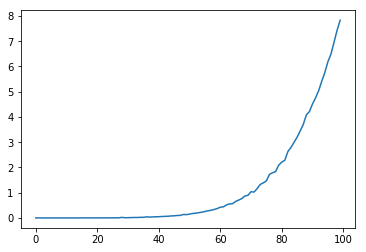

In [41]:
plt.plot(dot_times)

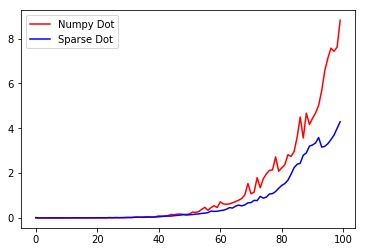

In [16]:
plt.plot(dot_times[:100],'r',sparse_times,'b')
plt.legend(['Numpy Dot', 'Sparse Dot'], loc='upper left')

In [20]:
import time

In [21]:
scipy_lu = []
for i in range(2,101):
    
    x = np.random.randn(i**2,i**2)
    diag = Diagonal(i,i)
    mat = d.from_dense(d.matrix)
    scipy_lu.append(return_time(la.lu,x))
    if i % 10 == 0:
        print(i)

10
20
30
40
50
60
70
80
90
100


In [ ]:
scipy_lu = []
for i in range(2,101):
    
    x = np.random.randn(i**2,i**2)
    diag = Diagonal(i,i)
    mat = d.from_dense(d.matrix)
    scipy_lu.append(return_time(la.lu,x))
    if i % 10 == 0:
        print(i)

In [ ]:
base_lu = []
for i in range(2,101):
    
    x = np.random.randn(i**2,i**2)
    diag = Diagonal(i,i)
    mat = diag.from_dense(diag.matrix)
    base_lu.append(return_time(lu_decomp,mat))
    if i % 10 == 0:
        print(i)

10
20
30
40


In [39]:
diag_lu = []
for i in range(2,101):
    
    x = np.random.randn(i**2,i**2)
    diag = Diagonal(i,i)
    start = time.time()
    _=diag.plu()
    end = time.time()
    diag_lu.append(end-start)
    if i % 10 == 0:
        print(i)

10
20
30
40
50
60
70
80
90
100


In [29]:
print(scipy_lu[-1])

8.743863105773926


In [35]:
d.n

10

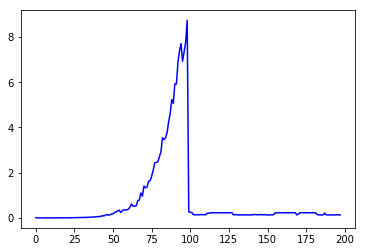

In [44]:
plt.plot(scipy_lu,'b')

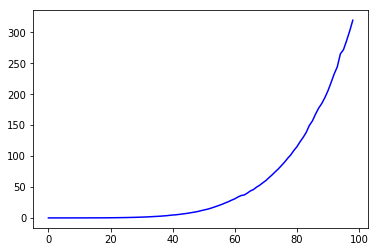

In [42]:
plt.plot(diag_lu,'b')

In [56]:
from scipy import sparse,dot

In [63]:
scipy_times = []
for i in range(2,101):
    
    x = np.random.randn(i**2,i**2)
    diag = Diagonal(i,i)
    sparse_matrix = sparse.csr_matrix(diag.from_dense(diag.matrix))
    scipy_times.append(return_time(sparse.csr_matrix.dot,(sparse_matrix,x)))
    if i % 10 == 0:
        print(i)

10
20
30
40
50
60
70
80
90
100


In [65]:
scipy_times_csc = []
for i in range(2,101):
    
    x = np.random.randn(i**2,i**2)
    diag = Diagonal(i,i)
    sparse_matrix = sparse.csc_matrix(diag.from_dense(diag.matrix))
    scipy_times_csc.append(return_time(sparse.csc_matrix.dot,(sparse_matrix,x)))
    if i % 10 == 0:
        print(i)

10
20
30
40
50
60
70
80
90
100


In [ ]:

for j in range(diag.area):

    basis = diag.basis[j%diag.d]
    updatedable = [b for b in basis if b<=j]

    for ii,i in enumerate(basis):
        if i <= j:
            if len(updatedable) == 1:
                value = PA[ii,j]
            else:
                value= PA[ii,j] - (U[updatedable[:ii+(1-j%2)],j] *L[basis[ii],updatedable[:ii+(1-j%2)]]).sum()
            U[i,j] = value

    updatedable = [b for b in basis if b>j]
    for ii,i in enumerate(basis):
        if i > j:
            if len(updatedable)>1:
                value = PA[ii,j] / U[j,j]
            else:
                value = (PA[ii,j] -(U[basis[:ii],j] * L[updatedable,basis[:ii]]).sum()) / U[j,j]

            L[i,j] = value

In [352]:
(PA[ii,j] -(U[basis[:ii],j] * L[updatedable,basis[:ii]]).sum())

IndexError: shape mismatch: indexing arrays could not be broadcast together with shapes (2,) (3,) 

In [357]:
basis[:3]

array([0, 2, 4])

In [358]:
L[updatedable]

array([[ 0.14708815,  0.        ,  0.28584839,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ],
       [-0.03876399,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ]])

In [388]:
U[updatedable[:ii],j] 

array([ 0.,  0.])

In [385]:
basis[:ii]

array([0, 2, 4])

In [362]:
basis[:2]

array([0, 2])

In [364]:
L[updatedable,basis[:2]]

array([ 0.14708815,  0.        ])

In [353]:
U[basis[:ii],j] 

array([ 0.49743217,  1.61354463,  0.        ])

In [457]:
L = np.eye(d.area)
U = np.zeros((d.area,d.area))
#P = create_pivot(d.from_dense(d.matrix))
#PA = get_permutation_dense(d)


In [494]:
j=5
basis = d.basis[j%d.d]
updatedable = [b for b in basis if b<=j]

In [495]:
for ii,i in enumerate(basis):
    if i <= j:
        if len(updatedable) == 1:
            value = PA[ii,j]
        else:
            value= PA[ii,j] - (U[updatedable[:ii+(1-j%2)],j] *L[basis[ii],updatedable[:ii+(1-j%2)]]).sum()
        U[i,j] = value

In [467]:
U[j,j]

1.6670677661895752

In [496]:
updatedable = [b for b in basis if b>j]
for ii,i in enumerate(basis):
    if i > j:
        if len(updatedable)>d.d:
            print("shortcut")
            value = PA[ii,j] / U[j,j]
        else:
            value = (PA[ii,j] -(L[basis[ii],range(j)] * U[range(j),j]).sum()) / U[j,j]

        L[i,j] = value

In [394]:
(PA[2,j] -(U[basis[:2],j] * L[updatedable,basis[:2]]).sum()) / U[j,j]

0.28584839330296491

In [425]:
(L[basis[3],basis[:2]] * U[range(j),j]).sum()

-0.019282454051511223

In [421]:
U[range(0),0]

array([], dtype=float64)

In [426]:
(PA[3,j] -(L[basis[3],basis[:2]] * U[range(j),j]).sum() )/U[j,j]

-0.39356854289575832

array([[ 0.14708815,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ,  0.        ,  0.        ],
       [-0.03876399,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  1.        ,  0.        ]])

In [404]:
L[updatedable,basis[:2]]

array([ 0.14708815,  0.        ])

In [497]:
print(U[:j+2,:j+2])

[[ 1.1679976   0.          0.49743217  0.          0.814821    0.          0.        ]
 [ 0.          1.66706777  0.         -1.57935429  0.          0.07962431
   0.        ]
 [ 0.          0.          1.61354463  0.          0.42741828  0.          0.        ]
 [ 0.          0.          0.         -1.49196601  0.         -0.40317704
   0.        ]
 [ 0.          0.          0.          0.         -0.77604979  0.          0.        ]
 [ 0.          0.          0.          0.          0.         -1.44735213
   0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.        ]]


In [498]:
print(u[:j+2,:j+2])

[[ 1.1679976   0.          0.49743217  0.          0.814821    0.
   1.0599668 ]
 [ 0.          1.66706777  0.         -1.57935429  0.          0.07962431
   0.        ]
 [ 0.          0.          1.61354458  0.          0.42741829  0.
   0.32166478]
 [ 0.          0.          0.         -1.49196601  0.         -0.40317705
   0.        ]
 [ 0.          0.          0.          0.         -0.77604979  0.
  -1.71874595]
 [ 0.          0.          0.          0.          0.         -1.44735217
   0.        ]
 [ 0.          0.          0.          0.          0.          0.
  -2.63216019]]


In [499]:
print(L[:,:j+1])

[[ 1.          0.          0.          0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.        ]
 [-0.07655607  0.          1.          0.          0.          0.        ]
 [ 0.          0.13699252  0.          1.          0.          0.        ]
 [ 0.14708815  0.          0.28584839  0.          1.          0.        ]
 [ 0.          0.78469847  0.         -0.30324626  0.          1.        ]
 [-0.03876399  0.         -0.39356854  0.         -0.93899876  0.        ]
 [ 0.         -0.04221777  0.          0.3466691   0.         -0.45909872]]


In [500]:
print(ll[:,:j+1])

[[ 1.          0.          0.          0.          0.          0.        ]
 [ 0.          1.          0.          0.          0.          0.        ]
 [-0.07655607  0.          1.          0.          0.          0.        ]
 [ 0.          0.13699252  0.          1.          0.          0.        ]
 [ 0.14708815  0.          0.28584839 -0.          1.          0.        ]
 [ 0.          0.78469847  0.         -0.30324626 -0.          1.        ]
 [-0.03876399  0.         -0.39356854 -0.         -0.93899876 -0.        ]
 [ 0.         -0.04221777  0.          0.3466691  -0.         -0.45909872]]


In [390]:
L[6,2] = 0
L[4,2] = 0

In [401]:
0.53439551591873169 -(0.14708815  * 0.49743217 ) / 1.61354458  

0.33119352420912457

In [6]:
%%timeit 
get_permutation_dense(d)

11.1 µs ± 100 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [6]:
pa = get_permutation_dense(d)

In [13]:
%%timeit
plu(d,pa)

7.76 ms ± 45.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [16]:
%%timeit
plu(d,pa)

6.27 ms ± 23 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [ ]:
plu()

In [4]:

def get_permutation_dense(diag):
    diags = np.repeat(np.arange(0,diag.n),diag.d)
    updated = diag.row_based.copy()
    for c in range(updated.shape[1]):
        max_idx = np.argmax(np.abs(d.row_based[diags[c]:,c]))
        max_idx += diags[c]
        if (max_idx != diags[c]):
            order = swap_elements(list(range(updated.shape[0])),max_idx,diags[c])
            basis = diag.basis[c%diag.d]
            updated[:,basis] = updated[:,basis][[order],:]
    return updated
        
    
    
    

In [41]:
def create_pivot(mat):
    mat_size = mat.shape[0]
    p_blank = np.eye(mat_size)
    for c in range(mat_size):
        row = max(range(c, mat_size), key=lambda i: abs(mat[i,c]))
        if c != row:
            p_blank[[c,row]] = p_blank[[row,c]]
        
            
    return p_blank

In [3]:
def swap_elements(l,i,j):
    new = l.copy()
    new[i],new[j] = j,i
    return new

In [124]:
def pivot_matrix(M):
    """Returns the pivoting matrix for M, used in Doolittle's method."""
    m = len(M)

    # Create an identity matrix, with floating point values                                                                                                                                                                                            
    id_mat = [[float(i ==j) for i in range(m)] for j in range(m)]

    # Rearrange the identity matrix such that the largest element of                                                                                                                                                                                   
    # each column of M is placed on the diagonal of of M                                                                                                                                                                                               
    for j in range(m):
        row = max(range(j, m), key=lambda i: abs(M[i][j]))
        if j != row:
            # Swap the rows                                                                                                                                                                                                                            
            id_mat[j], id_mat[row] = id_mat[row], id_mat[j]

    return id_mat


In [17]:
d.basis

[array([ 0, 10, 20, 30, 40, 50, 60, 70, 80, 90]),
 array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91]),
 array([ 2, 12, 22, 32, 42, 52, 62, 72, 82, 92]),
 array([ 3, 13, 23, 33, 43, 53, 63, 73, 83, 93]),
 array([ 4, 14, 24, 34, 44, 54, 64, 74, 84, 94]),
 array([ 5, 15, 25, 35, 45, 55, 65, 75, 85, 95]),
 array([ 6, 16, 26, 36, 46, 56, 66, 76, 86, 96]),
 array([ 7, 17, 27, 37, 47, 57, 67, 77, 87, 97]),
 array([ 8, 18, 28, 38, 48, 58, 68, 78, 88, 98]),
 array([ 9, 19, 29, 39, 49, 59, 69, 79, 89, 99])]

In [40]:
def lu_decomp(mat):
    n = mat.shape[0]
    L = np.eye(n)
    U = np.zeros((n,n))
    P = create_pivot(mat)
    PA = P.dot(mat)
    for j in range(n):
        for i in range(j+1):
            #print('U')
            s1 = sum(U[k,j] * L[i,k] for k in range(i))
            #print(i,j,s1)
            U[i,j] = PA[i,j]- s1
            #print(U)
        for i in range(j, n):
            #print('L')
            s2 = sum(U[k,j] * L[i,k] for k in range(j))
            #print(i,j,s2,U[j,j])
            L[i,j] = (PA[i,j] - s2) / U[j,j]
            #print(L)
    return(P,L,U)

    

In [15]:
def plu(diag,PA):
    L = np.eye(diag.area)
    U = np.zeros((diag.area,diag.area))
    #P = create_pivot(diag.from_dense(diag.matrix))
    #PA = get_permutation_dense(diag)
    
    for j in range(diag.area):
    
        basis = diag.basis[j%diag.d]
        updatedable = [b for b in basis if b<=j]

        for ii,i in enumerate(basis):
            if i <= j:
                if len(updatedable) == 1:
                    value = PA[ii,j]
                else:
                    value= PA[ii,j] - (U[updatedable[:ii+(1-j%2)],j] *L[basis[ii],updatedable[:ii+(1-j%2)]]).sum()
                U[i,j] = value

        updatedable = [b for b in basis if b>j]
        for ii,i in enumerate(basis):
            if i > j:
                if len(updatedable)>1:
                    value = PA[ii,j] / U[j,j]
                else:
                    value = (PA[ii,j] -(U[basis[:ii],j] * L[updatedable,basis[:ii]]).sum()) / U[j,j]

                L[i,j] = value
            
    
    return(PA,L,U)
    
    

In [49]:
d = Diagonal(100,100)
mat = d.from_dense(d.matrix)

In [ ]:
%%timeit
p,l,u = la.lu(mat)

In [3]:
P,PA,L,U = d.plu()

In [4]:
PA

array([[-0.16942245,  1.64370525, -1.86522543, -0.13269112],
       [-0.05318164,  1.17119849,  0.8996135 , -0.04022091]])

In [47]:
retur

(100, 100)

In [50]:

pp,ll,uu = lu_decomp(mat)

KeyboardInterrupt: 

In [48]:
np.allclose()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [40]:
print(np.dot(L,U)[:,0])

[ 1.24610603  0.          0.          0.          0.1129849   0.          0.
  0.          0.46757331  0.          0.          0.          0.08257036
  0.          0.          0.        ]


In [285]:
PA.sum()

2.1676505003124475

In [13]:
np.allclose(PA.sum(),L.dot(U).sum())

True

In [509]:
for i in range(d.area):
    print('column {}'.format(i))
    print(L.dot(U)[:,i].sum())
    print(PA[:,i].sum())
    print('\n')

column 0
-1.2403408587
-1.2403408587


column 1
0.0918840765953
0.0918840765953


column 2
-3.49678850919
-3.49678850919


column 3
-0.375688582659
-0.375688582659


column 4
0.450707294047
0.450707294047


column 5
-0.791108518839
-0.791108518839


column 6
-2.14767384529
-2.14767384529


column 7
-0.0029793381691
-0.0029793381691


